In [13]:
# imports
import rosbags_converter as rc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seatrac_enums import CST_E
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress

In [3]:
# User Variables

vehicle = '/coug2'
ROSBAGS_DIR = "/home/bjm255/couguv/CoUGARs/bag" + vehicle 
SAVES_DIR = "coug2"

MISSION_KEYWORDS = ["11.0"]

VERBOSE=True

In [12]:
# Convert Rosbags
dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS, verbose=True)
if len(dataframes)==0:
    print("converting rosbags")
    typestore = rc.generate_typestore("../../cougars-ros2/src")
    dataframes = rc.convert_rosbags(ROSBAGS_DIR, typestore, 
                                    keywords=MISSION_KEYWORDS,verbose=VERBOSE)
    rc.save_to_csv(dataframes, SAVES_DIR, verbose=VERBOSE)
    dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS)

Loading /home/bjm255/couguv/CoUGARs/cougars-base-station/postprocessing/coug2/converted__RB_SYSID11.0-2025-01-17-12-08-01


In [5]:
# display topics by rosbag
for path, topics in dataframes.items():
    print(f"{path}:\n\t{list(topics.keys())}")

converted__RB_SYSID11.0-2025-01-17-12-08-01:
	['/coug2/depth_data', '/coug2/dvl/data', '/coug2/dvl/position', '/coug2/fix', '/coug2/battery/data', '/coug2/kinematics/command', '/coug2/extended_fix', '/coug2/pressure/data', '/coug2/dvl/dead_reckoning', '/coug2/controls/command', '/coug2/dvl/velocity', '/coug2/modem_imu', '/coug2/modem_status', '/coug2/dvl/dr_global', '/coug2/leak/data']


In [6]:
# lists dataframes by topic. 
# Assumes all vehicles have only one loaded mission and different namespaces
# Check previous cell output to confirm this is the case
dfsByTopic = {}
for topic_dfs in dataframes.values(): dfsByTopic.update(topic_dfs)
print(list(dfsByTopic.keys()))

['/coug2/depth_data', '/coug2/dvl/data', '/coug2/dvl/position', '/coug2/fix', '/coug2/battery/data', '/coug2/kinematics/command', '/coug2/extended_fix', '/coug2/pressure/data', '/coug2/dvl/dead_reckoning', '/coug2/controls/command', '/coug2/dvl/velocity', '/coug2/modem_imu', '/coug2/modem_status', '/coug2/dvl/dr_global', '/coug2/leak/data']


In [7]:
# Display a dataframe
print(f"DataFrame example:")
sampleDf = dfsByTopic[vehicle + "/dvl/position"]
print(sampleDf.iloc[:5])
print("...")

DataFrame example:
   header.stamp.sec  header.stamp.nanosec        header.frame_id  \
0        1737140882             481221566  dvl_A50/position_link   
1        1737140882             853473220  dvl_A50/position_link   
2        1737140883             222059212  dvl_A50/position_link   
3        1737140883             620285467  dvl_A50/position_link   
4        1737140883             990800030  dvl_A50/position_link   

           time  position.x  position.y  position.z   pos_std      roll  \
0  1.687109e+09    0.090054    0.051978    0.054497  0.217983  4.014024   
1  1.687109e+09    0.088224    0.048340    0.060953  0.218375  2.249677   
2  1.687109e+09    0.084024    0.050935    0.067825  0.218755  2.429948   
3  1.687109e+09    0.090423    0.056802    0.102468  0.219187  0.003888   
4  1.687109e+09    0.080189    0.046875    0.193017  0.219956  2.808418   

      pitch       yaw            type  status     format  
0  7.438230  8.251328  position_local       0  json_v3.1  
1  

In [9]:
# convert ros timestamps to pandas timestamps

for df in dfsByTopic.values():
    if "header.stamp.sec" in df.columns: 
        df["timestamp"] = pd.to_datetime(
            df["header.stamp.sec"] * 1_000_000_000 
            + df["header.stamp.nanosec"], unit='ns'
        )

bst_timestamps = dfsByTopic[vehicle + "/dvl/position"]["timestamp"]
print(f"RosBag timeframe:\t{bst_timestamps.min()} --- {bst_timestamps.max()}")

RosBag timeframe:	2025-01-17 19:08:02.481221566 --- 2025-01-17 19:10:17.599441944


/tmp/ipykernel_216717/3859131156.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_df["time_sec"] = (cropped_df["timestamp"] - start_time).dt.total_seconds()


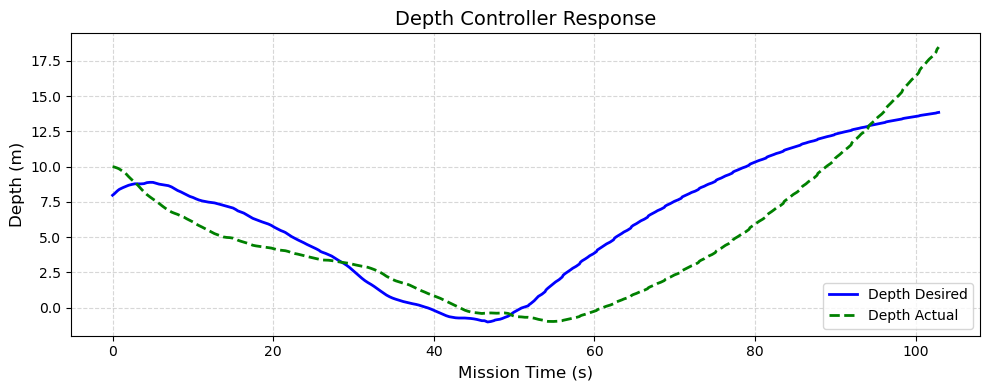

In [15]:

controls_debug = dfsByTopic[vehicle + "/dvl/position"]
cropped_df = controls_debug.iloc[100:501]

# Convert timestamp to seconds since mission start
start_time = cropped_df["timestamp"].iloc[0]
cropped_df["time_sec"] = (cropped_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x = cropped_df["time_sec"].to_numpy()
yx = cropped_df["position.x"].to_numpy()
yy = cropped_df["position.y"].to_numpy()
yz = cropped_df["position.z"].to_numpy()
#  = cropped_df["depth.actual"].to_numpy()
# y3 = cropped_df["depth.reference"].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(x, yx, label='Depth Desired', color='blue', linewidth=2)
ax.plot(x, yy, label='Depth Actual', color='green', linewidth=2, linestyle='--')
# ax.plot(x, y3, label='Depth Reference', color='red', linewidth=2, linestyle='--')

# Labels and formatting
ax.set_title('Depth Controller Response', fontsize=14)
ax.set_xlabel('Mission Time (s)', fontsize=12)
ax.set_ylabel('Depth (m)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()


/tmp/ipykernel_4113739/3156147582.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_df["time_sec"] = (cropped_df["timestamp"] - start_time).dt.total_seconds()


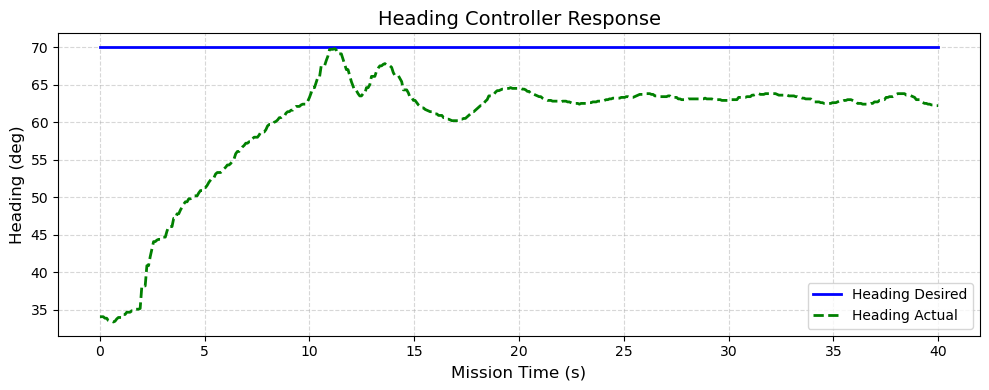

In [77]:

controls_debug = dfsByTopic[vehicle + "/controls/debug"]
cropped_df = controls_debug.iloc[0:501]

# Convert timestamp to seconds since mission start
start_time = cropped_df["timestamp"].iloc[0]
cropped_df["time_sec"] = (cropped_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x = cropped_df["time_sec"].to_numpy()
y1 = cropped_df["heading.desired"].to_numpy()
y2 = cropped_df["heading.actual"].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(x, y1, label='Heading Desired', color='blue', linewidth=2)
ax.plot(x, y2, label='Heading Actual', color='green', linewidth=2, linestyle='--')

# Labels and formatting
ax.set_title('Heading Controller Response', fontsize=14)
ax.set_xlabel('Mission Time (s)', fontsize=12)
ax.set_ylabel('Heading (deg)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()
